# Can an ML model differentiate my close friends better than my mom?

I have never done anything with images (preprocessing or classification) and the fun sample assignment really inspired me to learn about it by building a model recognizing my friends. I have 2 close friends since middle school and now we are juniors in college (wow!). They have the same first name, same last name, same major of studies and quite same personality. That's why my mom cannot really differentiate between them really well. They both wear glasses and have kinda similar appearance characteristics (Vietnamese girls!). In this project, I will train the model with their pictures of different face angles and at different times (middle school, high school and college). Yes, the big question is if the model can perform even better than mom at recognizing my two close friends.

Data have been collected from my personal archive (basically the Photos album in my iPhone). In recent updates for iPhone OS, we have a functionality to memorize faces of frequent people in the Photo album and categorize into different buckets. As a result, I can easily see pictures containing my friends' faces and gathered all of them. I also asked for my friends' consent and presented to them my ideas. They seemed so excited, so they are willing to send more pictures of themselves to me. I manually cropped the pictures to only their face and to the extent that I subjectively feel that their face can be quite visible. I also renamed the image file to their name with ordered numbers for the sake of data processing for the assignment. Since the dataset size is pretty small (n = 70 with 35 pictures of each friend), this manual process was not too painful, yet I still hope I can invest more time in automating this whole process next time! I created 2 folders to store their raw images - thutrang and quynhtrang (only different middle names)

## Install and Import Packages

Identify and Install necessary packages - for import image, convert into python-readable formats, compress or preprocess image data and start training the model

In [1]:
# the flag -q just helps to prevent output showing
%pip install -q opencv-python
%pip install -q Pillow
%pip install -q sklearn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from PIL import Image
import os, os.path
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import random

## Import, Clean and Preprocess Data

So currently, I just have all raw pictures of my friends. What I need to do is to extract key information in these pictures, aka their face, and somehow convert it into some sorts of numbers to represent their face in different pictures so that these numbers can be inputted into the model which can learn patterns and make predictions given unseen data. 

The general strategy here is to first standardize all pictures since raw ones are in different sizes. After that, I will use the pre-trained Haar Cascade Classifier model from OpenCV package to detect faces in all standardized pictures.  Since OpenCV only accepts grayscale images, I will just convert all colored images into grayscale ones. During my manual preprocessing stage, I already cropped pictures such that there is only one face of one friend per picture, so I only accept pictures with one face detected. This makes my training dataset contain 51 observations in total, pretty equally divided for 2 outcome categories. 


Standardization of image sizes helps improve the performance of the algorithm to detect faces (in terms of both efficiency and speed) thanks to consistency of all inputs. The Haar Cascade algorithm implements sliding window approach which basically divides the picture into small windows of different sizes after different iterations (based on parameter scaleFactor), scans windows through the entire picture and classifies that window as containing faces or non-faces. Therefore, with images of different sizes, the function, with pre-defined parameters of window sliding approach will struggle to find as many faces in images as possible since some pictures can be too small or too big to recognize as face and will take quite more time to make accurate classifications. Standardization here helps choose a set of optimal parameters to detect more faces with accuracy. I played around with the function to tune parameters and ended up getting 51 observations in my training dataset. When I printed all images to verify results, the classifier detected faces very exactly with only 1 or 2 pictures not capturing the full face region

In [3]:
# import images from a directory: https://stackoverflow.com/questions/22282760/filenotfounderror-errno-2-no-such-file-or-directory

# GLOBAL VARIABLES
STANDARD_SIZE = (256, 256) # for images
cwd = os.getcwd()
# folder to store images of 2 different friends
TTRANG = cwd + "/thutrang"
QTRANG = cwd + "/quynhtrang"
VALID_IMAGES = (".jpg",".gif",".png",".tga")

imgs = []

def standardize_size(path):
    """
    Takes in a folder of image for one friend of mine, 
    performs some basic check for all images,
    converts them into the standard image size,
    and saves all new standardized images separately
    
    Returns none
    
    Parameters:
    ---------------------------------
    path: str
        A path which represents the address of where all images of one friend are stored
    """
    # loop through all files in the directory
    for f in os.listdir(path):
        # check if its image file and its not resized yet
        if f.lower().endswith(VALID_IMAGES) and "resized" not in f:
            holder = Image.open(os.path.join(path, f))
            if holder.size != (256, 256):
                image_std = holder.resize(STANDARD_SIZE)
                image_std.save(path + "/resized" + f)

standardize_size(TTRANG)
standardize_size(QTRANG)

As I said before, Haar cascade algorithms implements sliding window approach to examine small rectangles in the image and classify them as face or non-face objects. In each rectangle they scan through, they will use an integral image representation (where each pixel value is the sum of all pixel values to the left and above the original pixel in the original picture). With integral images, the algorithm uses multiple weak classifiers (like trees of depth only 1) and assigns sample weights to these classifiers to quantify how important the single classifier is in making the final prediction. With multiple iterations and efficient training from a lot of data (faces and non-faces), the algorithm will learn pretty much patterns in pixel values to classify faces.

In [4]:
def detect_faces(path):
    """
    Takes in a folder of image for one friend of mine,
    detects the faces in all images,
    and saves all images with their corresponding 4 coordinates of the face region
    in a hashmap for future use.
    
    Returns the path of either friend's images and the hashmap storing images - coordinates
    
    Parameters:
    ---------------------------------
    path: str
        A path which represents the address of where all images of one friend are stored
    """
    hashmap = {}
    # initialize the model to detect face in an image
    # reference to debug: https://stackoverflow.com/questions/53926657/215assertion-failed-src-empty-in-function-cvcvtcolor-with-cvimread
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # loop through all standardized images in the folder
    for f in os.listdir(path):
        if f.lower().startswith("resized"):
            img_path = os.path.join(path, f)
            img = cv2.imread(img_path)
            if img is not None:
                # convert to grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(img, scaleFactor = 1.05, minNeighbors = 5, minSize = (20, 20), maxSize = (200, 200))
                # only get images with only 1 face to ensure accurate detection and eliminate noise
                if len(faces) > 0 and len(faces) < 2:
                    for (x, y, w, h) in faces:
                        # face region
                        detect = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 4)
                        # store in hashmap: image - coordinates
                        hashmap[f] = (x, y, w, h)
                    # for grader, you can uncomment the next two lines of code to see images of faces detected in training data
                    # plt.imshow(detect)
                    # plt.show()
    return path, hashmap

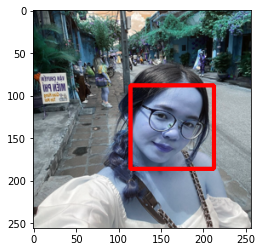

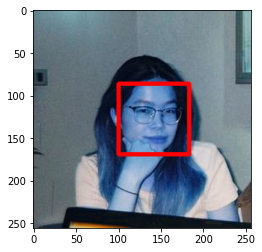

In [5]:
def random_example(path):
    """
    Takes in a folder of image for one friend of mine, 
    chooses one random photo and show the image of the face region detected
    
    Returns none
    
    Parameters:
    ---------------------------------
    path: str
        A path which represents the address of where all images of one friend are stored
    """
    hashmap = detect_faces(path)[1]
    i = int(random.uniform(0, 26))
    
    photo_list = list(hashmap.keys())
    coordinates = hashmap[photo_list[i]]
    img_path = os.path.join(path, photo_list[i])
    img = cv2.imread(img_path)
    detect = cv2.rectangle(img, (coordinates[0], coordinates[1]), (coordinates[0]+coordinates[2], coordinates[1]+coordinates[3]), (255, 0, 0), 4)
    plt.imshow(detect)
    plt.show()
random_example(QTRANG)
random_example(TTRANG)

The face region is defined by 4 coordinates in the picture to form a rectangle over that face region. I stored the results in a hashmap where keys are valid images and values are corresponding coordinates of face region. After that, I just cropped the face region out of the picture and saved all of face-only pictures in a new directory.

In the new directory, I once again standardized the size of face-only pictures so that inputs for the model have consistency, which is beneficial for training process. I converted the standardized face-only pictures into a 256x256x3 numpy array which has 256x256 pixel values of 3 colors RGB. I also maintained a list to store labels, looped through all images, tracked the labels based on filename and add binary values to the list. The corresponding index will ensure properly ordered data observations. 

In [6]:
def create_dir(directory = "cropped_images"):
    """
    Creates the new directory with given directory name
    
    Returns the absolute directory path
    
    Parameters:
    ---------------------------------
    directory: str
        The name of the directory we want to create
    """
    cwd = os.getcwd()
    # check if it already exists
    if not os.path.exists(os.path.join(cwd, directory)):
        os.mkdir(os.path.join(cwd, directory))
        return os.path.join(cwd, directory)
    return os.path.join(cwd, directory)

def crop_faces(path, hashmap, directory = "cropped_images"):
    """
    Crops all valid photos with their corresponding coordinates of the detected face region
    Saves them in a new directory
    
    Returns none
    
    Parameters:
    ---------------------------------
    path: str
        The folder of all my friend's images
    hashmap: dict
        Valid standardized images - coordinates of face region
    directory: string
        The new directory to save newly cropped images
    """
    target = create_dir(directory)
    for image in hashmap:
        # make sure the image has not been cropped
        if "cropped" not in image:
            coordinates = hashmap[image]
            image_path = os.path.join(path, image)
            holder = cv2.imread(image_path)
            # convert the image to arrays for the sake of cropping with coordinates
            # convert back to image
            # reference for how to crop images: https://www.askpython.com/python/examples/crop-an-image-in-python
            face_image_array = holder[coordinates[1]:coordinates[1] + coordinates[3], coordinates[0]:coordinates[0] + coordinates[2]]
            face_image = Image.fromarray(face_image_array)
            face_image_path = "cropped_" + image
            face_image.save(os.path.join(target, face_image_path))
        
crop_faces(TTRANG, detect_faces(TTRANG)[1])
crop_faces(QTRANG, detect_faces(QTRANG)[1])

In [7]:
def standardize_cropped_images(directory):
    """
    For all face-region-only images, we standardize their sizes,
    convert them into numpy arrays for the model - feature data,
    and labelling observations for model use - outcome data
    
    Returns feature data and outcome data as arrays
    
    Parameters:
    ---------------------------------
    directory: string
        The new directory to save newly cropped images
    """
    imgs = []
    labels = []
    for f in os.listdir(directory):
        if f.lower().endswith(VALID_IMAGES) and f.lower().startswith("cropped"):
            cropped_image = Image.open(os.path.join(directory, f))
            if cropped_image.size != STANDARD_SIZE:
                cropped_image_std = cropped_image.resize(STANDARD_SIZE)
                cropped_image_std.save(directory + "/resized" + f)
    for f in os.listdir(directory):
        if f.lower().endswith(VALID_IMAGES) and f.lower().startswith("resizedcropped"):
            img = Image.open(os.path.join(directory, f))
            # convert image to numpy array: https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/
            img_array = np.asarray(img)
            imgs.append(img_array)
            # since I do not modify original image file name but just add prefix, 
            # still keep track of which photo is whose
            if "qtrang" in f:
                labels.append(0)
            elif "ttrang" in f:
                labels.append(1)
    return imgs, labels

res = standardize_cropped_images(os.path.join(cwd, "cropped_images"))

As can be seen, I broke down the whole process of importing, cleaning and preprocessing data into multiple parts. I believe refactoring code is for the sake of future maintainable use and debugging process. If I chose to process raw pictures to clean numpy arrays of standardized face-region pictures in only one single loop function, it would become complicated and confusing for readers. Also, should any bugs come up, it will also be very hard to keep track of how images are processed and how every extracted key information is effectively stored.

## Explorative Data Analysis

In [8]:
print("The shape of each observation's feature data: ", res[0][0].shape)
X = np.array([i.flatten() for i in res[0]])
y = np.array(res[1])
print(len(X))
print(len(y))
print("The number of training data for QuynhTrang: ", sum(y==0))
print("The number of training data for ThuTrang: ", sum(y==1))
print("The number of elements in one observation's feature data: ", len(X[0]))
print("The range of pixel values for each photo: ", min([min(x) for x in X]), max([max(x) for x in X]))
print("Our label data: ", np.unique(y))
# please uncomment these codes to see histograms of pixel values in each image
# for the sake of presentation, i uncomment them to avoid long outputs
# for x in X:
#     plt.hist(x)
#     plt.show()

The shape of each observation's feature data:  (256, 256, 3)
51
51
The number of training data for QuynhTrang:  26
The number of training data for ThuTrang:  25
The number of elements in one observation's feature data:  196608
The range of pixel values for each photo:  0 255
Our label data:  [0 1]


X and y will be our feature data and outcome data inputted in training model. They are both lists of length 51 for 51 valid observations we have. Here, our images are colored and have 256x256 pixels. I flatten the 256x256x3 arrays so that model can work well with 1d arrays. As a result, each observation's feature data is a 1d array with 196608 pixel values store in X. Correspondingly, we have the list y including binary label values for the sake of training outcome data. The number of observations for each outcome category is pretty similar.

I also tried to plot histograms of pixel values for each image to examine the distributions over pixel values in my training data. It's pretty surprising to me that most images have normal pixel values. Some photos have very skewed pixel data, which can be because of overall light in the picture. However, normality of the majority of training data gives me insight in choosing models to train.

Text(0.5, 1.0, 'The histogram over pixel values of the 38th image')

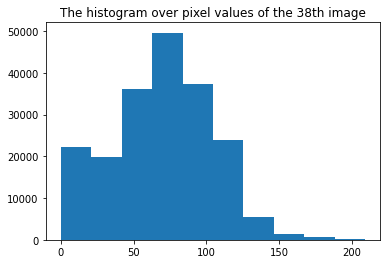

In [9]:
# A random example
i = int(random.uniform(0, 51))
plt.hist(X[i])
plt.title(f'The histogram over pixel values of the {i}th image')

## Task Discussion

The general task here is to train a model with photos of my two best friends such that the model can recognize their faces with new images. This is a binary classification problem. Basically, the model, after being trained, just needs to classify the image containing which friend of mine's face. 

In [10]:
def set_up(X, y):
    """
    Splits data into training and testing sets
    Standardizes feature data
    Initializes models
    
    Returns preprocessed, split dataset and initialized models 
    
    Parameters:
    ---------------------------------
    X: array
        Feature data - flattened pixels of an image
    y: array
        Label data - binary arrays
    """
    # split data
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size = 0.2, random_state = int(random.uniform(0, 1001)))
    # standardize data to be normally distributed around 0 with unit variance
    X_trainset_std = (X_trainset - np.mean(X_trainset)) / np.std(X_trainset)
    X_testset_std = (X_testset - np.mean(X_testset)) / np.std(X_testset)
    # initialize model
    logit_model = LogisticRegression(max_iter=1000)
    nb_model = GaussianNB()
    return X_trainset_std, X_testset_std, y_trainset, y_testset, logit_model, nb_model

## Model Selection

Since the dataset, after cleaning and processing, is pretty small (N = 51), I believe neural networks might not be suitable because the complexities in neural networks will not optimize model learning and predictions to small dataset. Therefore, I am thinking about more simple model which can avoid overfitting small training dataset. I will implement a Logistic Regression since this is a binary classification problem. Also, I will contrast the performance of a Logisitc Regression model with a Naive Bayes model. Naive Bayes is also another basic kind of Bayesian models which rely mainly on conditional probabilities. Since a simple explorative data analysis hints me on major image data have pixel values following a normal distribution and pixel values are also not a count or categorical variable, I would choose Gaussian Naive Bayes here as the model to contrast with Logistic Regression. 

### Logistic Regression

The general idea of logistic regression is to create a linear combination of all feature data (here: pixel values), add noise, use a sigmoid function to map the values to a range from 0 to 1, which is basicaly to predict the probability that the label is 1. After that, we just need to use a threshold value (default 0.5) to classify one observation to binary categories. Now, let's get to the training process.

Basically, our parameters here are noise b and weights w assigned correspondingly each feature data. Our job is to feed the model with training data such that the model is updating on weights and noise and for each observation, our result (the linear combination), after being mapped to [0, 1] range, will match the real data as closely as possible. 

Logistic regression uses maximum likelihood function to produce a set of parameters that will maximize the likelihood of getting actual data given our feature data. 

So we have z = b0 + b1 * x1 + b2 * x2 + ... + b196608 * x196608 as our linear combination
our sigmoid function will be something like e^z / (1 + e^z) which represents the probability our binary outcome is 1, so we have the probability our binary outcome is 0 is 1 - (e^z / (1 + e^z)) = 1 / (1 + e^z)

Since all data points are independent, the likelihood for our set of parameters to create outcomes most closely to the actual outcome data will be the product of all individual probabilities.
Since the probabilities differ for real outcome data of 0 and 1, we will write a function to handle both cases
L_i(w, b) for a data point = p(z_i)^y_i  * (1 - p(z_i)^(1 - y_i)
Here, our y value will cancel the other term.

L(w, b) for all data points in our training set will be the product of all individual L_i(w, b)
We will use log here for the same of computational precision
--> log L(w, b) = the sum of all L_i(w, b) with L_i(w, b) = y_i log(p(z_i)) + (1 - y_i) * log(1 - p(z_i))

Here, we already have our log-likelihood function which we should maximize. To find optimal weights in the fastest way, we will use gradient descent method which basically computes the partial derivative of the function with regards to each single weights and change the weights to the direction with highest impact to the maximum likelihood function.

### Gaussian Naive Bayes

The general idea of Gaussian Naive Bayes is to use conditional probabilities to compute how likely an observation belong to a class given individual feature data. Then, it will sum all the conditional probabilities for all feature data and picks the class with highest likelihood as the prediction for an observation.

Recall the Bayes' Theorem, we have
Posterior = Prior * Likelihood / Evidence

Prior is computed by the proportion of data with each category we have in our training set
Likelihood is computed by how likely we get this feature data value in the whole distribution over the whole feature data of one category

So basically, from the entire training dataset, after we get the prior, we construct the probability distribution function over the feature data of one category. Therefore, what we have now is just a prior generally derived for all training dataset and the likelihood probability distribution over feature data for each category.

So when a new data observation comes in, we just have to compute the posterior probability of belonging to each category given each feature data by comparing that value to the normal distribution we constructed in the likelihood part. We sum posterior values from all feature data for each category and our prediction should be the category with the highest posterior probabilities.

We can see that this model does not directly have a loss function to minimize on, mainly relies on the maximum likelihood function for training data and makes a lot of assumptions (especially independence between feature data, which seems to be loose for images pixels). Therefore, its simplicity might be a weakness.

## Model Training

Since our dataset is very small, to optimize learning and avoid overfitting, cross-validation is definitely an approach worth a try. It helps the model get more exposed to different chunks of data and the model's performance is also better evaluated.

With the dataset size of only 51 data points, I already saved one-fifth of them in the test set. Therefore, there are only 40 data points left. Since we still want the validation fold to be large enough to evaluate the model, I created a list of possible number of folds from 3 to 7 only. For each number of folds, I computed the mean score of model performance with accuracy metrics. As a result, I can produce a plot of model training performance with different numbers of folds.

In [11]:
def cross_validation_split(X, y, n_folds):
    """
    Performs cross validation to our data - splitting data into k pretty equally sized folds
    
    Returns already well-split feature data and outcome data
    
    Parameters:
    ---------------------------------
    X: array
        Feature data - flattened pixels of an image
    y: array
        Label data - binary arrays
    n_folds: int
        The number of folds in cross-validation
    """
    # adapted from code in CS156 PCW Session 6
    X_split, y_split = [], []
    X_copy, y_copy = list(X), list(y)
    fold_size = len(X) // n_folds
    # for the last fold, we just need add the rest of data to make a fold
    for i in range(n_folds - 1):
        fold_X, fold_y = [], []
        while len(fold_X) < fold_size and len(fold_y) < fold_size:
            index = int(random.uniform(0, len(X_copy)))
            fold_X.append(X_copy.pop(index))
            fold_y.append(y_copy.pop(index))
        X_split.append(fold_X)
        y_split.append(fold_y)
            
    X_split.append(X_copy)
    y_split.append(y_copy)
    return X_split, y_split

In [12]:
def contrast_LogReg_NaiveBayes_withCV(X, y, logit_model, nb_model, n_folds):
    """
    Compares model performance in training with cross-validation
    
    Returns mean scores after cross-validation of 2 models
    
    Parameters:
    ---------------------------------
    X: array
        Feature data - flattened pixels of an image
    y: array
        Label data - binary arrays
    logit_model: object
        The Logistic Regression model
    nb_model: object
        The Naive Bayes model
    n_folds: int
        The number of folds in cross-validation
    """
    logit_accuracy_lst = []
    nb_accuracy_lst = []
    # divide data into folds
    X_split, y_split= cross_validation_split(X, y, n_folds)
    for i in range(len(X_split)):
        # get the testing fold
        X_test, y_test = X_split[i], y_split[i]
        # merge all the rest into training set
        X_train = np.concatenate(X_split[:i] + X_split[i+1:])
        y_train = np.concatenate(y_split[:i] + y_split[i+1:])
        
        # after fitting and predicting, storing accuracy with corresponding number of folds
        logit_model.fit(X_train, y_train)
        pred_logit = logit_model.predict(X_test)
        accuracy_logit = accuracy_score(y_test, pred_logit)
        logit_accuracy_lst.append(accuracy_logit)
        
        nb_model.fit(X_train, y_train)
        pred_nb = nb_model.predict(X_test)
        accuracy_nb = accuracy_score(y_test, pred_nb)
        nb_accuracy_lst.append(accuracy_nb)
    return np.mean(logit_accuracy_lst), np.mean(nb_accuracy_lst)

## Model Testing and Performance Metrics with Visualizations

After performing cross validation, I will test the models by seeing how it make predictions with the test set (new data). Through this way, I also contrast the performance of 2 different models - Logistic Regression and Naive Bayes.

First, since splitting data can pose bias to the model training process since the number of images for one category can be higher that the other in the training dataset. Therefore, to account for these bias, I run the training and testing process 5 times in total with random splitting to see how 2 models will perform. After cross validation, I produce the plot to see average scores of 2 models given different numbers of folds. Then, for testing data, I will use Confusion Matrix to see the percentage of correctly identified testing subjects for each model. I also use another metric - ROC-AUC to holistically evaludate both model performance. Since our dataset is pretty small, the testing set, after being randomly split, can be very imbalanced in terms of two outcome categories. Therefore, the metric ROC-AUC helps us understand which model classifies the positive (aka ThuTrang my friend) more correctly. I provided plots for both metric in each iteration.

Iteration 0 - Training Process:


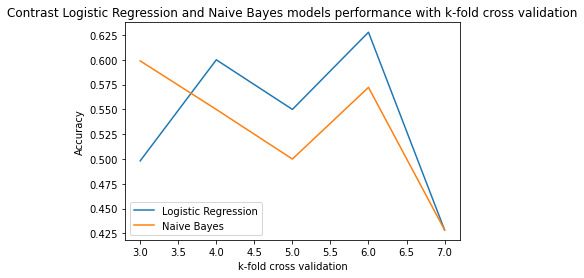

Iteration 0 - Testing with accuracy metric:


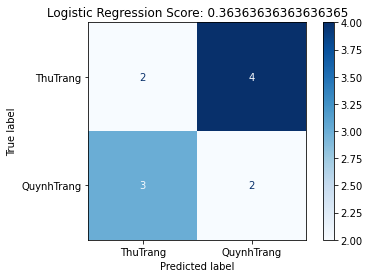

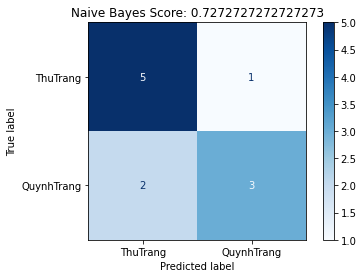

Iteration 0 - Testing with ROC-AUC metric:


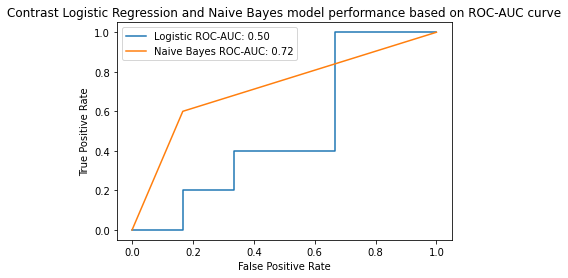

Iteration 1 - Training Process:


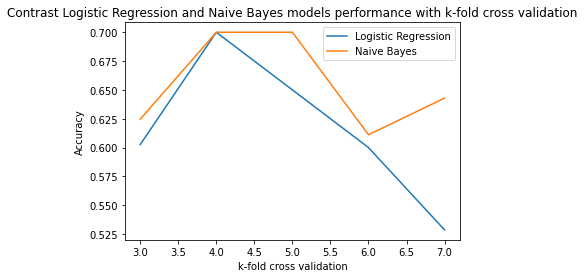

Iteration 1 - Testing with accuracy metric:


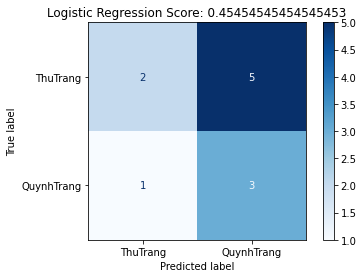

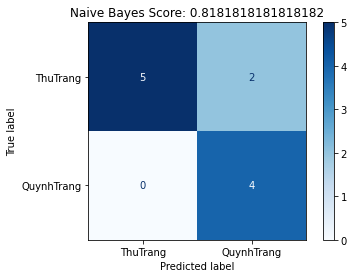

Iteration 1 - Testing with ROC-AUC metric:


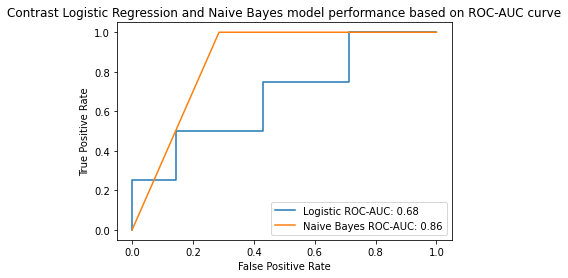

Iteration 2 - Training Process:


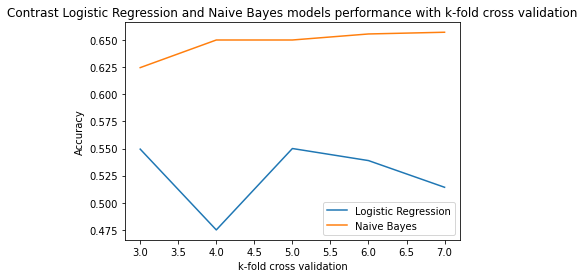

Iteration 2 - Testing with accuracy metric:


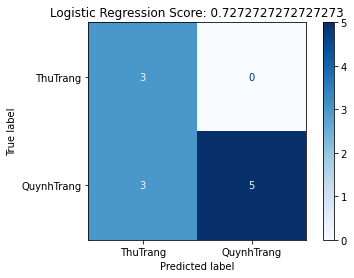

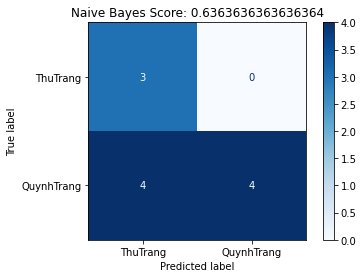

Iteration 2 - Testing with ROC-AUC metric:


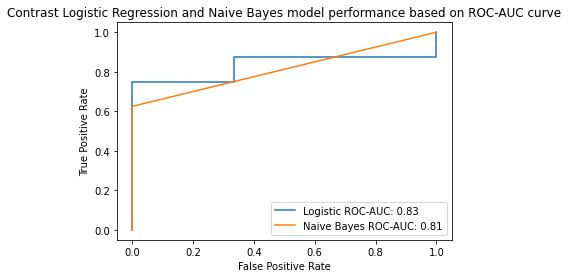

Iteration 3 - Training Process:


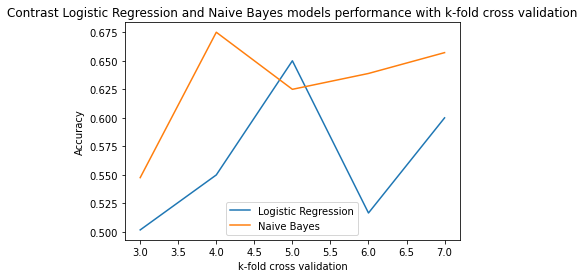

Iteration 3 - Testing with accuracy metric:


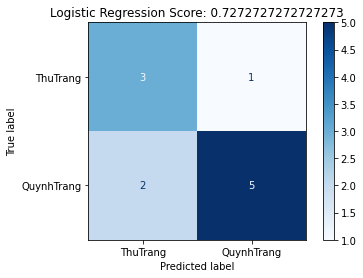

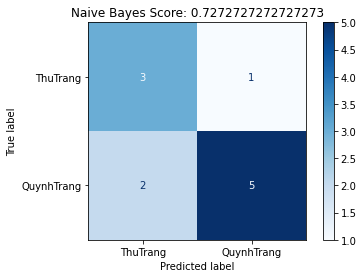

Iteration 3 - Testing with ROC-AUC metric:


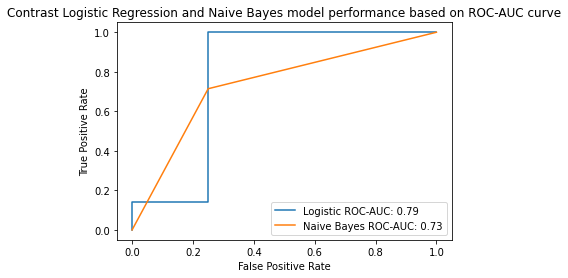

Iteration 4 - Training Process:


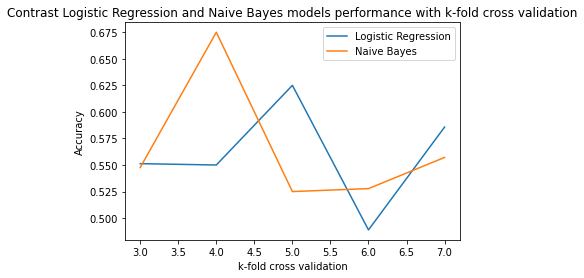

Iteration 4 - Testing with accuracy metric:


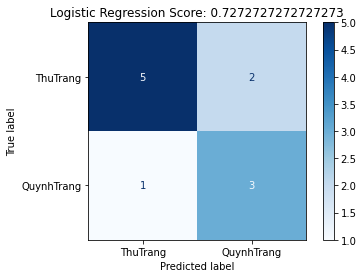

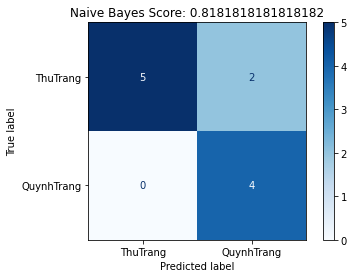

Iteration 4 - Testing with ROC-AUC metric:


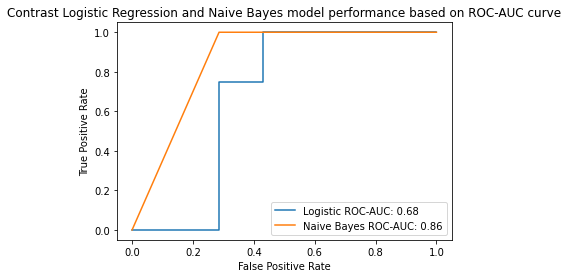

In [13]:
for iteration in range(5):
    # initialization
    X_trainset_std, X_testset_std, y_trainset, y_testset, logit_model, nb_model = set_up(X, y)
    # experiment with different folds
    n_folds = [i for i in range(3, 8)]
    logit = {}
    nb = {}
    for n_fold in n_folds:
        # get model accuracy for each number of folds
        logit_accuracy, nb_accuracy = contrast_LogReg_NaiveBayes_withCV(X_trainset_std, y_trainset, logit_model, nb_model, n_fold)
        logit[n_fold] = logit_accuracy
        nb[n_fold] = nb_accuracy
    print(f'Iteration {iteration} - Training Process:')
    plt.plot(logit.keys(), logit.values(), label = "Logistic Regression")
    plt.plot(nb.keys(), nb.values(), label = "Naive Bayes")
    plt.xlabel("k-fold cross validation")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Contrast Logistic Regression and Naive Bayes models performance with k-fold cross validation")
    plt.show()
    
    ### TESTING
    
    print(f'Iteration {iteration} - Testing with accuracy metric:')
    logit_predictions = logit_model.predict(X_testset_std)
    logit_accuracy = accuracy_score(y_testset, logit_predictions) 

    nb_predictions = nb_model.predict(X_testset_std)
    nb_accuracy = accuracy_score(y_testset, nb_predictions)

    classes = ['ThuTrang', 'QuynhTrang']
    cm_logit = confusion_matrix(y_testset, logit_predictions)
    disp_logit = ConfusionMatrixDisplay(confusion_matrix=cm_logit, display_labels=classes)
    disp_logit.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
    plt.title(f"Logistic Regression Score: {logit_accuracy}")

    cm_nb = confusion_matrix(y_testset, nb_predictions)
    disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=classes)
    disp_nb.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
    plt.title(f"Naive Bayes Score: {nb_accuracy}")
    plt.show()
    
    
    print(f'Iteration {iteration} - Testing with ROC-AUC metric:')
    logit_preds = logit_model.predict_proba(X_testset_std)[:, 1]
    nb_preds = nb_model.predict_proba(X_testset_std)[:, 1]

    logit_curve = roc_curve(y_testset, logit_preds)
    nb_curve = roc_curve(y_testset, nb_preds)

    plt.plot(logit_curve[0], logit_curve[1], label="Logistic ROC-AUC: %.2f" % roc_auc_score(y_testset, logit_preds))
    plt.plot(nb_curve[0], nb_curve[1], label="Naive Bayes ROC-AUC: %.2f" % roc_auc_score(y_testset, nb_preds))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Contrast Logistic Regression and Naive Bayes model performance based on ROC-AUC curve")
    plt.legend()
    plt.show()

Now, time to interpret results and visualizations! Note that since I set a random state randomly, so everytime we run the code, results will be different because data split is different. There are some common insights I noticed after running the code multiple times with 5 iterations:

1. There is no model performing strictly better than the other and both models' performance is also pretty unstable and not so impressive. 

    The testing accuracy for both models in general can only reach around 0.5-0.7, sometimes can exceed 0.7 and sometimes can go down to 0.2 or 0.3. Even though we do not really set an accuracy threshold for the big question yet, this is of our interest to evaluate our models. Of course, our dataset is pretty small, so models might have to struggle to balance between learning and predicting. Also, both Logistic Regression and Naive Bayes are simple models with certain assumptions (e.g. linearity for LogReg or continuous normality and feature data independence for Naive Bayes) which our data are not best suited for. Therefore, this model specification should also be kept in mind.


2. Sometimes in one iteration, one model is strictly better than the other in cross-validation results, yet can still perform worse in testing data. 

    Due to the inherent randomness in our model training process, sometimes our training data (or even our fold) and our testing data can be very biased. As a result, even though we tried our best to minimize this bias and prevent overfitting through cross-validation and experimental number of folds, it is not a panacea to the constraint of small dataset and possibly biased data splits. Bearing this in mind will help us understand what are some necessary improvements to train the model and to enrich our dataset.
    
    
3. Accuracy and ROC-AUC are not necessarily consistent metrics.

    Since both metrics point to different things, they give different answers to which model performs better in testing set. Accuracy is a simple metric when it just measures the proportion of correctly identified observations in the test set. It basically ignores the bias of data and of the model or some key priorities in our general problem. However, ROC-AUC accounts for this in terms of imbalanced dataset because it calculates the proportion of true positives and false positives given different threshold values of classification. Therefore, in some cases, there are few positives in our test set (which can make sense given small dataset and random splits), so wrong classification of these positives does not affect accuracy much because true negatives will increase the proportion. However, ROC-AUC will penalize this model very badly. Even though in this big question, negatives and positives are equally important (unlike some real-life situations), knowing the difference and how they are evaluating our models still helps in providing a holistic judgement. 

## Executive Summary

In my first ever end-to-end ML pipeline, I have imported images, detected faces, cropped only face region, converted into python-readable format (numpy array) and standardized the data for the sake of the model. I trained models with cross validation with different number of folds, produced plots of mean scores for two models, and contrasted the two models' performance in test set with 2 metrics - accuracy and ROC-AUC. I also provided visualizations about how models make predictions given actual values and their performance on test set with 2 metrics values. Overall, both models do not provide stable impressive performance in different trials. Instead, both metrics have high variance in the model performance, ranging from 0.3 to even 0.8, which is attributable to randomness in splitting data and dataset small size. 

Possible extensions to this project include:

- Data augmentation to enrich the dataset. I am pretty sure with large dataset, we can implement different complex models and their performance given new data will be better since they have more space to learn from data without the fear of overfitting in small dataset.

- Complex models. I also need to try with more complex models, especially those specialized in image classification, namely CNNs or KNNs. 

- Automation in preprocessing images. Currently, I manually cropped the pictures a bit to make sure only one face of one friend is included in the pic so that in my code, I just mainly resized, detected the face and converted into arrays. I believe that an automation engine in handling with images (extracting my friend's face and eliminating noise) will increase the number of images we have.

## References

Lehn, A. (2022). CS156 Final Assignment. https://drive.google.com/file/d/12nbTuzwcgg4-2JtEmqZFBLQurKql5TLQ/view?pli=1

OpenCV (Nov 17, 2022). Haar Cascade Open-Source Project. https://github.com/opencv/opencv/tree/master/data/haarcascades

Scikit-learn (2023). Naive Bayes Documentation. https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

Starmer, J. (Jan 15, 2019). AdaBoost, Clearly Explained!!!. https://www.youtube.com/watch?v=LsK-xG1cLYA&t=1012s

Starmer, J. (Jun 3, 2020). Naive Bayes, Clearly Explained!!!. https://www.youtube.com/watch?v=O2L2Uv9pdDA